In [128]:
import numpy as np, matplotlib.pyplot as plt
import scipy.optimize as optimize
from astropy.io import ascii as asc, fits as pyfits
from analysis.composite_errors import random_pdf
from analysis.MC_contours import contours, confidence

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [129]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
sfr = np.array(corr_tbl['met_dep_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])
corr_sfrs = sfr+filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & (stlr_mass >= CUTOFF_MASS))[0]
n = len(good_sig_iis)

In [130]:
sigmas = corr_tbl['meas_errs'][good_sig_iis].data
mass = stlr_mass[good_sig_iis]
sfrs = corr_sfrs[good_sig_iis]

z_sp = zspec0[good_sig_iis]
badz_iis = np.array([x for x in range(len(z_sp)) if z_sp[x] < 0 or z_sp[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}
ffs = filts[good_sig_iis]
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    z_sp[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1
    
mz_data = np.vstack([mass, z_sp]).T

eqn_str = r'$\log(SFR) = \alpha \log(M) + \beta z + \gamma$'
def func(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

params00, pcov = optimize.curve_fit(func, mz_data, sfrs)
perr = np.sqrt(np.diag(pcov))

### nbia_mainseq sample

In [131]:
newha = pyfits.open(FULL_PATH+'NewHa/NewHa.fits')
newhadata = newha[1].data

tempm = newhadata['LOGM']
tempsfr = newhadata['LOGSFR_HA']
templha = newhadata['L_HA']
tempagn = newhadata['AGN']
good_ii = np.where((tempm > 0) & (tempsfr != 0) & (templha != 0) & (tempagn != 1))[0]
newhadata = newhadata[good_ii]

newha_zspec = newhadata['Z_SPEC']
newha_logm = newhadata['LOGM']
newha_logm_err = newhadata['LOGM_ERR']
newha_logsfrha = newhadata['LOGSFR_HA']
newha_logsfrha_uperr = newhadata['LOGSFR_HA_UPERR']
newha_logsfrha_lowerr = newhadata['LOGSFR_HA_LOWERR']
newha_logsfr_err = np.sqrt(newha_logsfrha_uperr**2/2 + newha_logsfrha_lowerr**2/2)

newha_mzdata = np.vstack([newha_logm, newha_zspec]).T

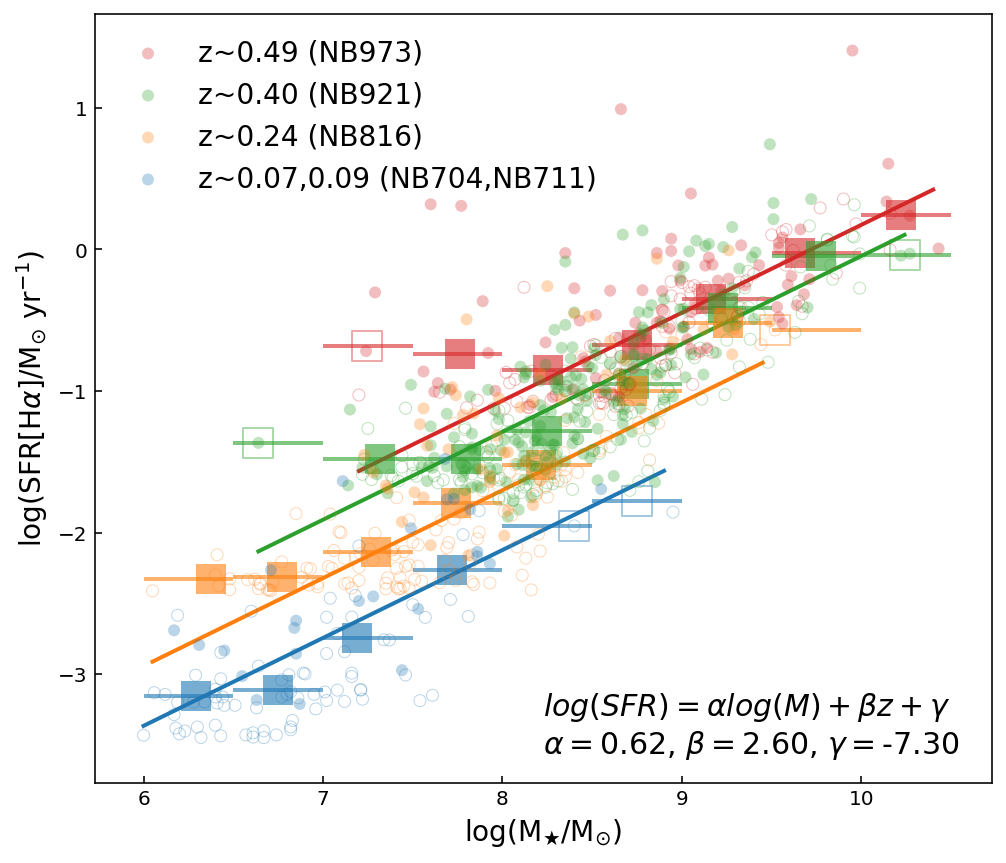

In [132]:
from plot_nbia_mainseq import make_redshift_graph
import matplotlib as mpl

# defining an approximate redshift array for plot visualization
z_arr0 = np.array([7045.0, 7126.0, 8152.0, 9193.0, 9749.0])/6563.0 - 1
z_arr0 = np.around(z_arr0, 2)
z_arr  = np.array(z_arr0, dtype='|S9')
z_arr[0] = ",".join(z_arr[:2])
z_arr = np.delete(z_arr, 1)
z_arr  = np.array([x+'0' if len(x)==3 else x for x in z_arr])


cwheel = [np.array(mpl.rcParams['axes.prop_cycle'])[x]['color'] for x in range(4)]
newha_col = np.array(mpl.rcParams['axes.prop_cycle'])[4]['color']

f, ax = plt.subplots()
make_redshift_graph(f, ax, z_arr, corr_sfrs, stlr_mass, zspec0, filts, good_sig_iis, cwheel)
plt.subplots_adjust(hspace=0.01, wspace=0.01, right=0.99, top=0.98, left=0.1, bottom=0.09)

plt.show()

## overlaying new_ha

In [133]:
nh_z_arr = np.append(z_arr, '%.2f'%np.mean(newha_zspec))
nh_cwheel = [np.array(mpl.rcParams['axes.prop_cycle'])[x]['color'] for x in range(5)]

sfrs_with_newha  = np.concatenate((corr_sfrs, newha_logsfrha))
mass_with_newha  = np.concatenate((stlr_mass, newha_logm))
zspec_with_newha = np.concatenate((zspec0, newha_zspec))
filts_with_newha = np.concatenate((filts, np.array(['NEWHA']*len(newha_logsfrha))))
mz_data_with_newha = np.concatenate((mz_data, newha_mzdata))

nh_good_sig_iis = np.concatenate((good_sig_iis, np.arange(len(corr_sfrs), len(sfrs_with_newha))))
nh_ffarr=['NB7', 'NB816', 'NB921', 'NB973', 'NEWHA']
nh_llarr=['NB704,NB711', 'NB816', 'NB921', 'NB973', 'NEWHA']

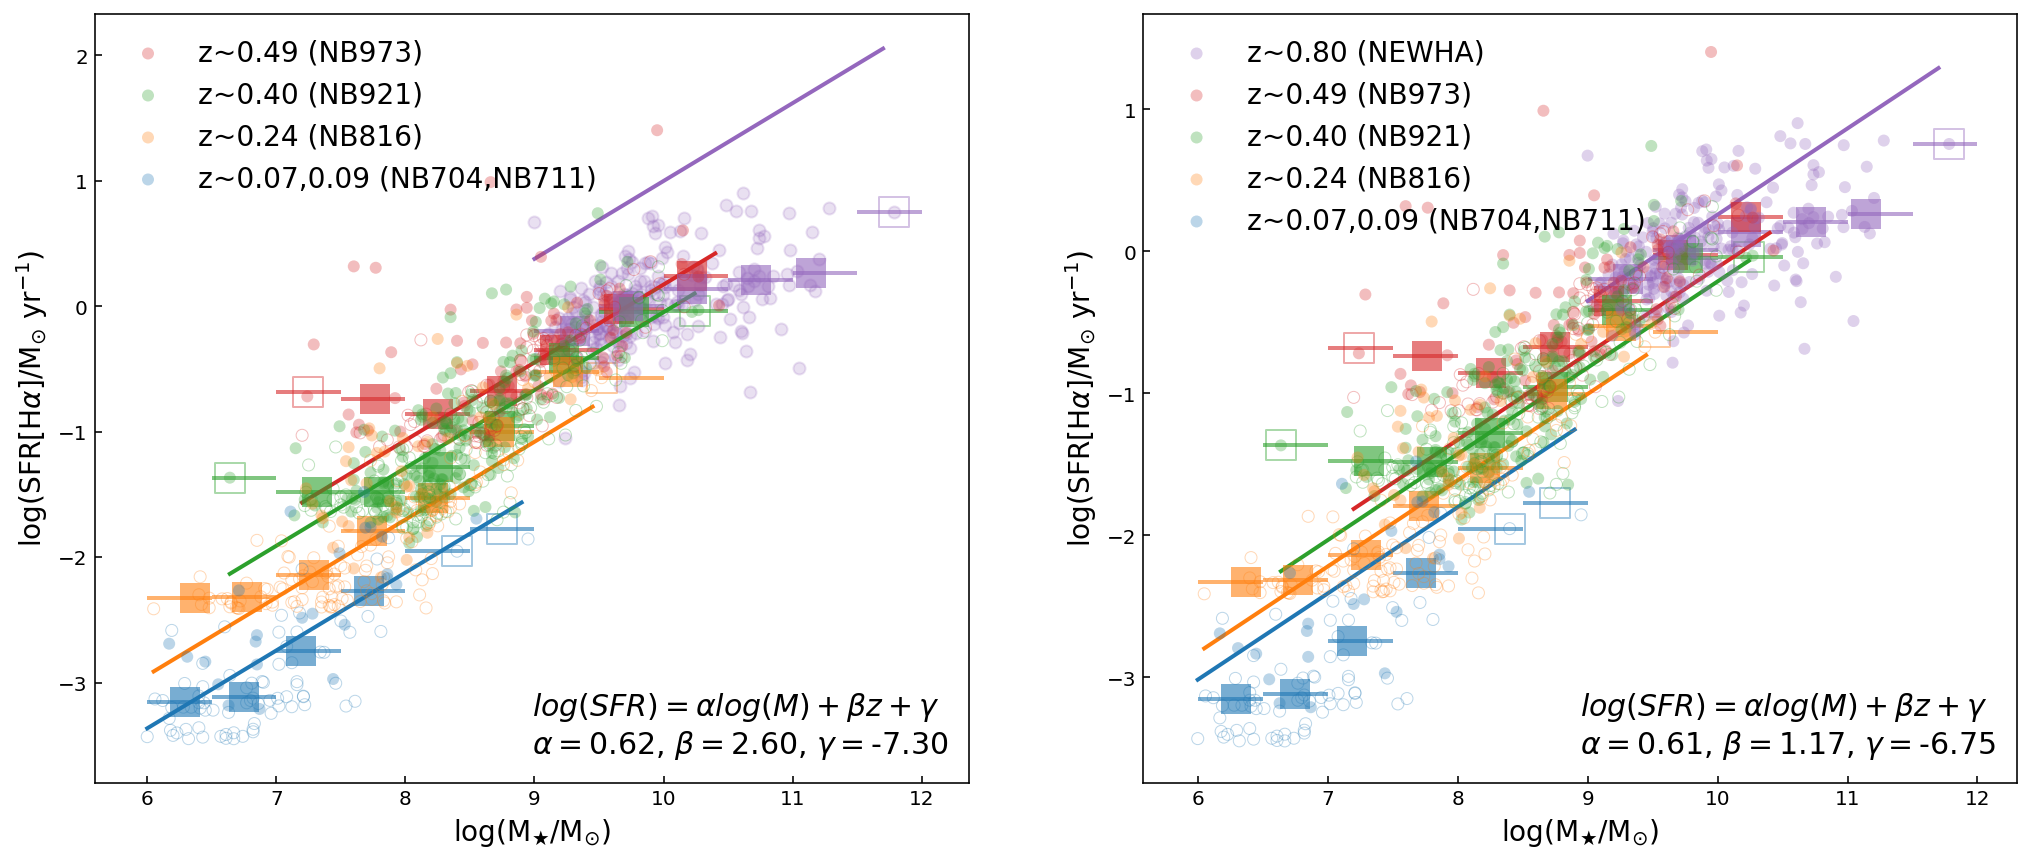

In [172]:
import plot_nbia_mainseq
reload(plot_nbia_mainseq)
from plot_nbia_mainseq import plot_zdep_avg_sfrs

f, axes = plt.subplots(1,2)
for i,ax in enumerate(axes):
    if i==0:
        make_redshift_graph(f, ax, z_arr, corr_sfrs, stlr_mass, zspec0, filts, good_sig_iis, cwheel)

        ax.plot(newha_logm, newha_logsfrha, 'o', c=newha_col, alpha=0.2, zorder=1)
        plot_zdep_avg_sfrs(ax, newha_logm, newha_logsfrha, newha_col)

        mrange = np.arange(min(newha_logm), max(newha_logm), 0.1)
        avgz = np.array([np.mean(newha_zspec)]*len(mrange))
        tmpdata = np.vstack([mrange, avgz]).T
        ax.plot(mrange, func(tmpdata, *params00), color=newha_col, lw=2)
    else:
        make_redshift_graph(f, ax, nh_z_arr, sfrs_with_newha, mass_with_newha, zspec_with_newha, 
                            filts_with_newha, nh_good_sig_iis, nh_cwheel,
                            ffarr=nh_ffarr, llarr=nh_llarr)


plt.subplots_adjust(hspace=0.01, right=0.99, top=0.98, left=0.1, bottom=0.09)
f.set_size_inches(15,6)
plt.show()

sSFR a*log(1+z)+b params: [-0.18026247 -9.59047802]


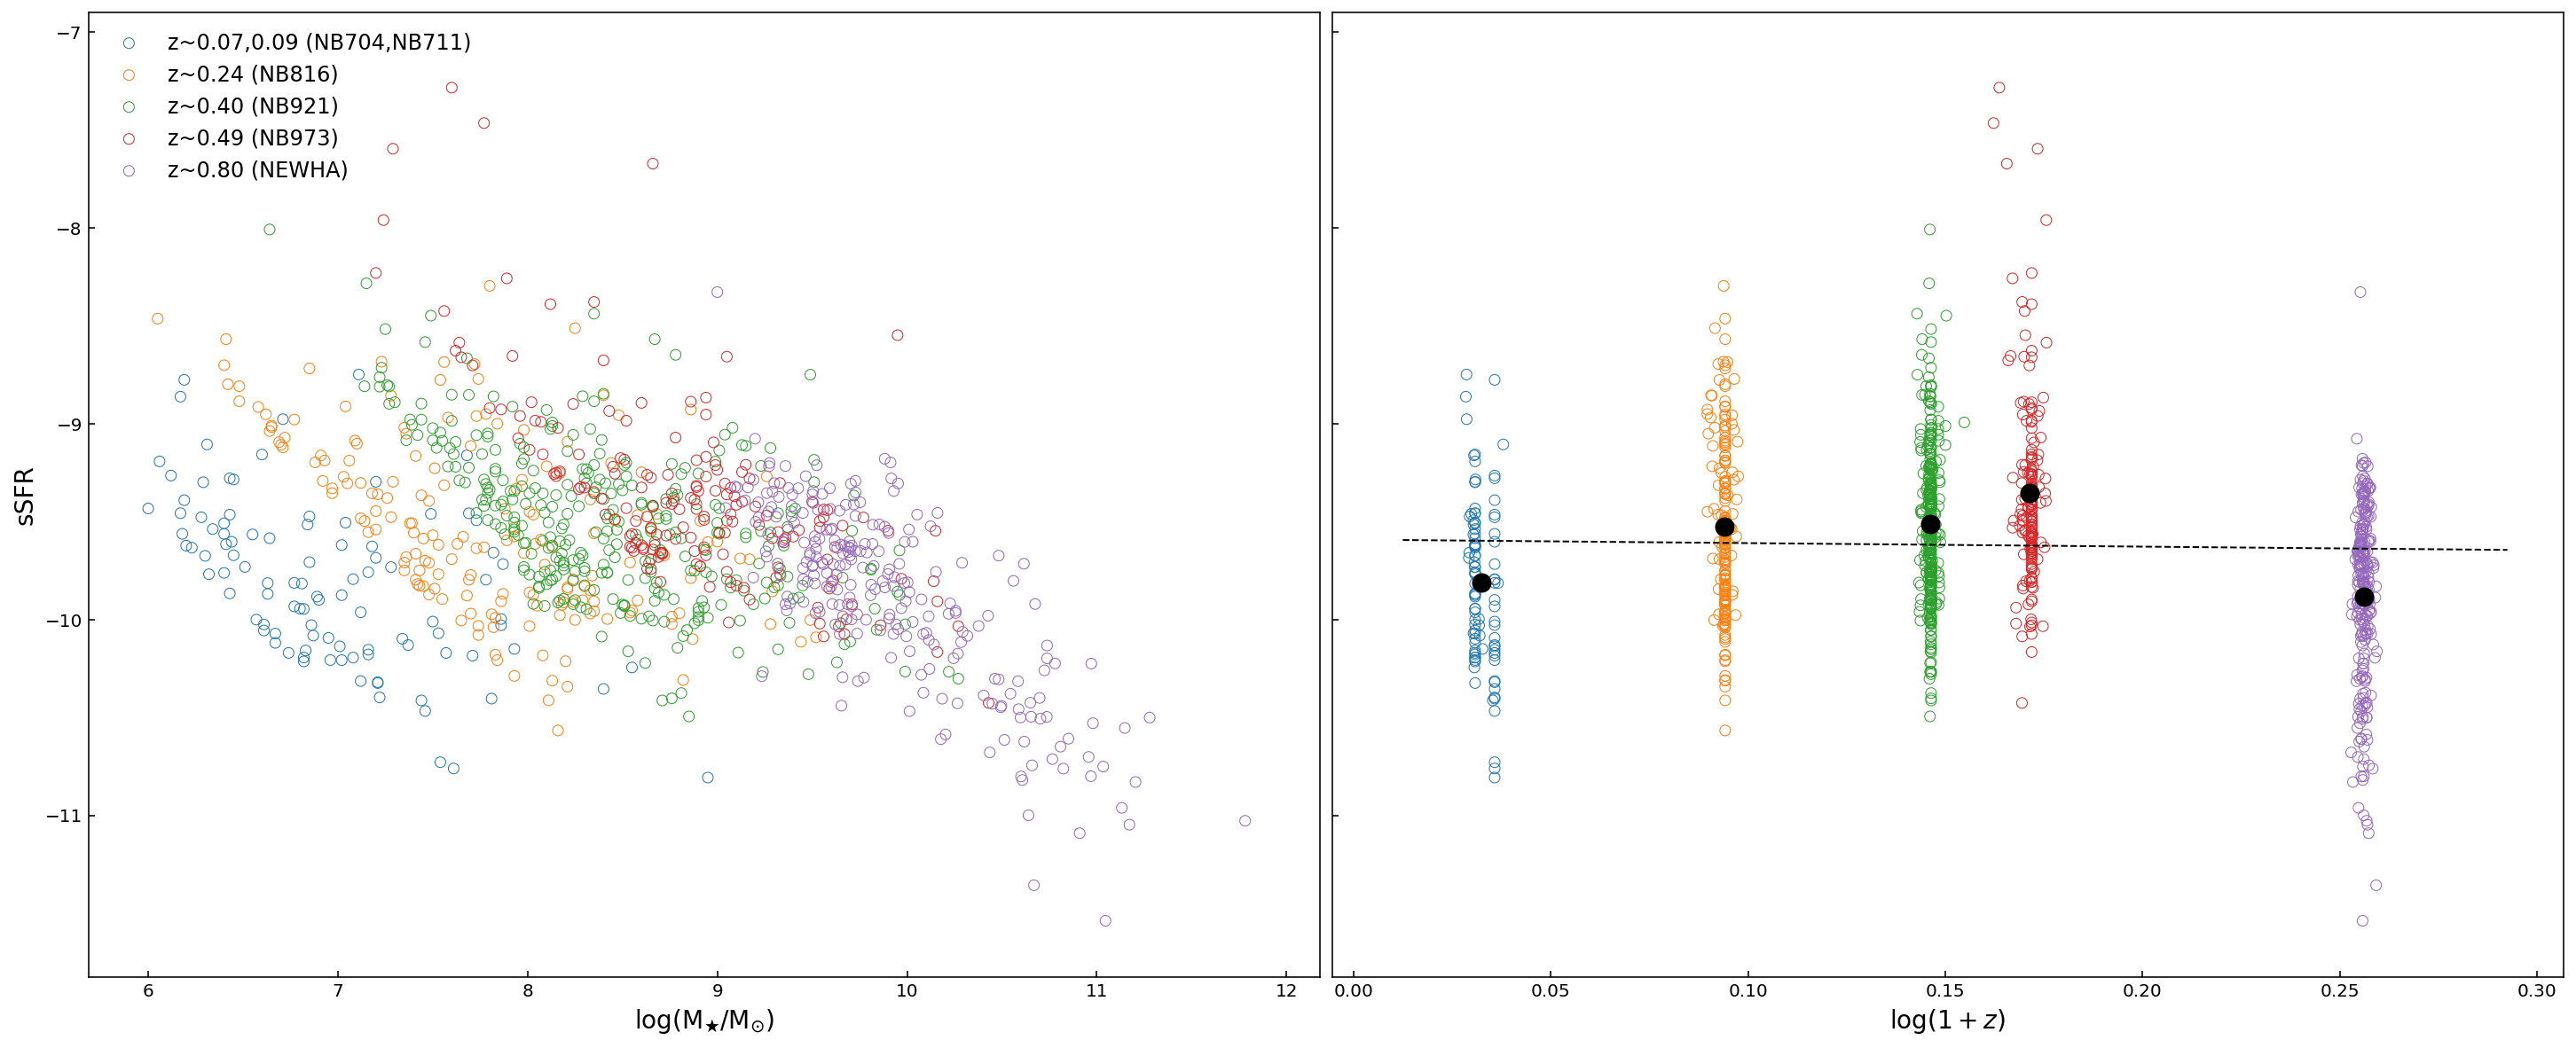

In [135]:
import plot_nbia_mainseq
reload(plot_nbia_mainseq)
from plot_nbia_mainseq import make_ssfr_graph

f, axes = plt.subplots(1,2, sharey=True)

sfrs_with_newha00  = np.concatenate((sfrs, newha_logsfrha))
mass_with_newha00  = np.concatenate((mass, newha_logm))
zspec_with_newha00 = np.concatenate((z_sp, newha_zspec))
filts_with_newha00 = np.concatenate((ffs, np.array(['NEWHA']*len(newha_logsfrha))))

make_ssfr_graph(f, axes, sfrs_with_newha00, mass_with_newha00, filts_with_newha00, zspec_with_newha00, 
                nh_cwheel, nh_z_arr, ffarr=nh_ffarr, llarr=nh_llarr)

f.set_size_inches(25,10)

### using HA luminosity and then correcting that with nii/ha instead of directly using SFR lumin in the table

In [137]:
from mainseq_corrections import niiha_oh_determine

sSFR a*log(1+z)+b params: [-0.35173366 -9.57479399]


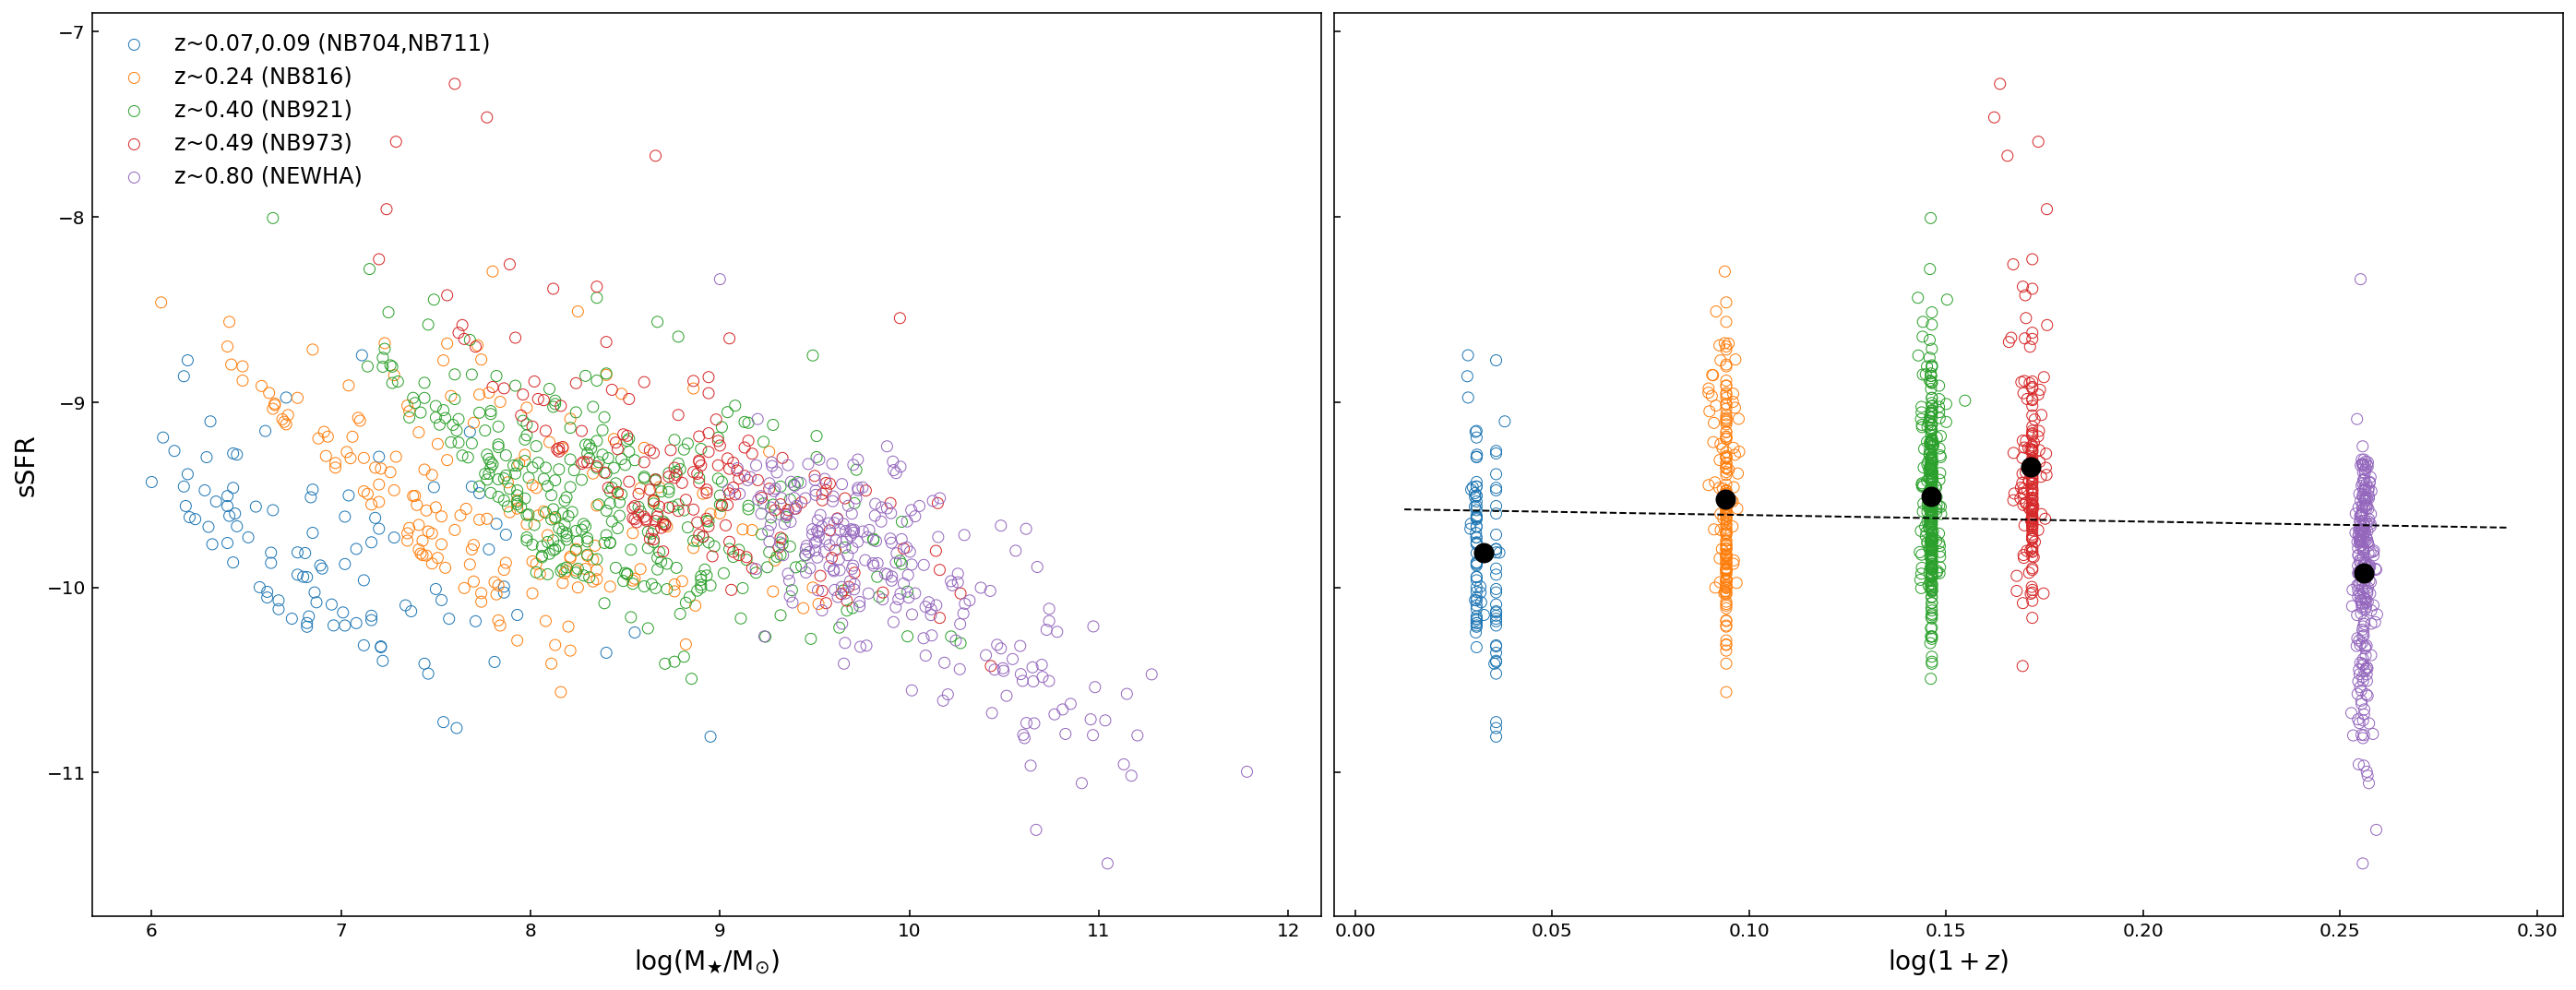

In [188]:
# metallicity dep SFRs
l_ha = np.log10(newhadata['L_HA']) + 41 # ha luminosity
nii_ha_best = newhadata['NII_HALPHA_BEST']
nii6583_ha = nii_ha_best * 2.96/(1+2.96)

logOH = niiha_oh_determine(np.log10(nii6583_ha), 'PP04_N2') - 12   # since this code estimates log(O/H)+12
y = logOH + 3.31 
log_SFR_LHa = -41.34 + 0.39*y + 0.127*y**2 # metallicity-dependent SFR

logSFR = log_SFR_LHa + l_ha  # + 0.4*A_HA #-(np.log10(7.9/1.8) - 42)


f, axes = plt.subplots(1,2, sharey=True)

sfrs_with_newha00  = np.concatenate((sfrs, logSFR))
mass_with_newha00  = np.concatenate((mass, newha_logm))
zspec_with_newha00 = np.concatenate((z_sp, newha_zspec))
filts_with_newha00 = np.concatenate((ffs, np.array(['NEWHA']*len(newha_logsfrha))))

make_ssfr_graph(f, axes, sfrs_with_newha00, mass_with_newha00, filts_with_newha00, zspec_with_newha00, 
                nh_cwheel, nh_z_arr, ffarr=nh_ffarr, llarr=nh_llarr)

# [ax.set_ylim(ymax=8) for ax in axes]
f.set_size_inches(24,9)
plt.show()

### overlaying new_ha sample, but fitting to sSFR instead of SFR 
(SFRs taken at 'face value' from the NewHa dataset)

In [ ]:
# log(sSFR) = \alpha'*log(M)**2 + \alpha*log(M) + \beta*z + \gamma

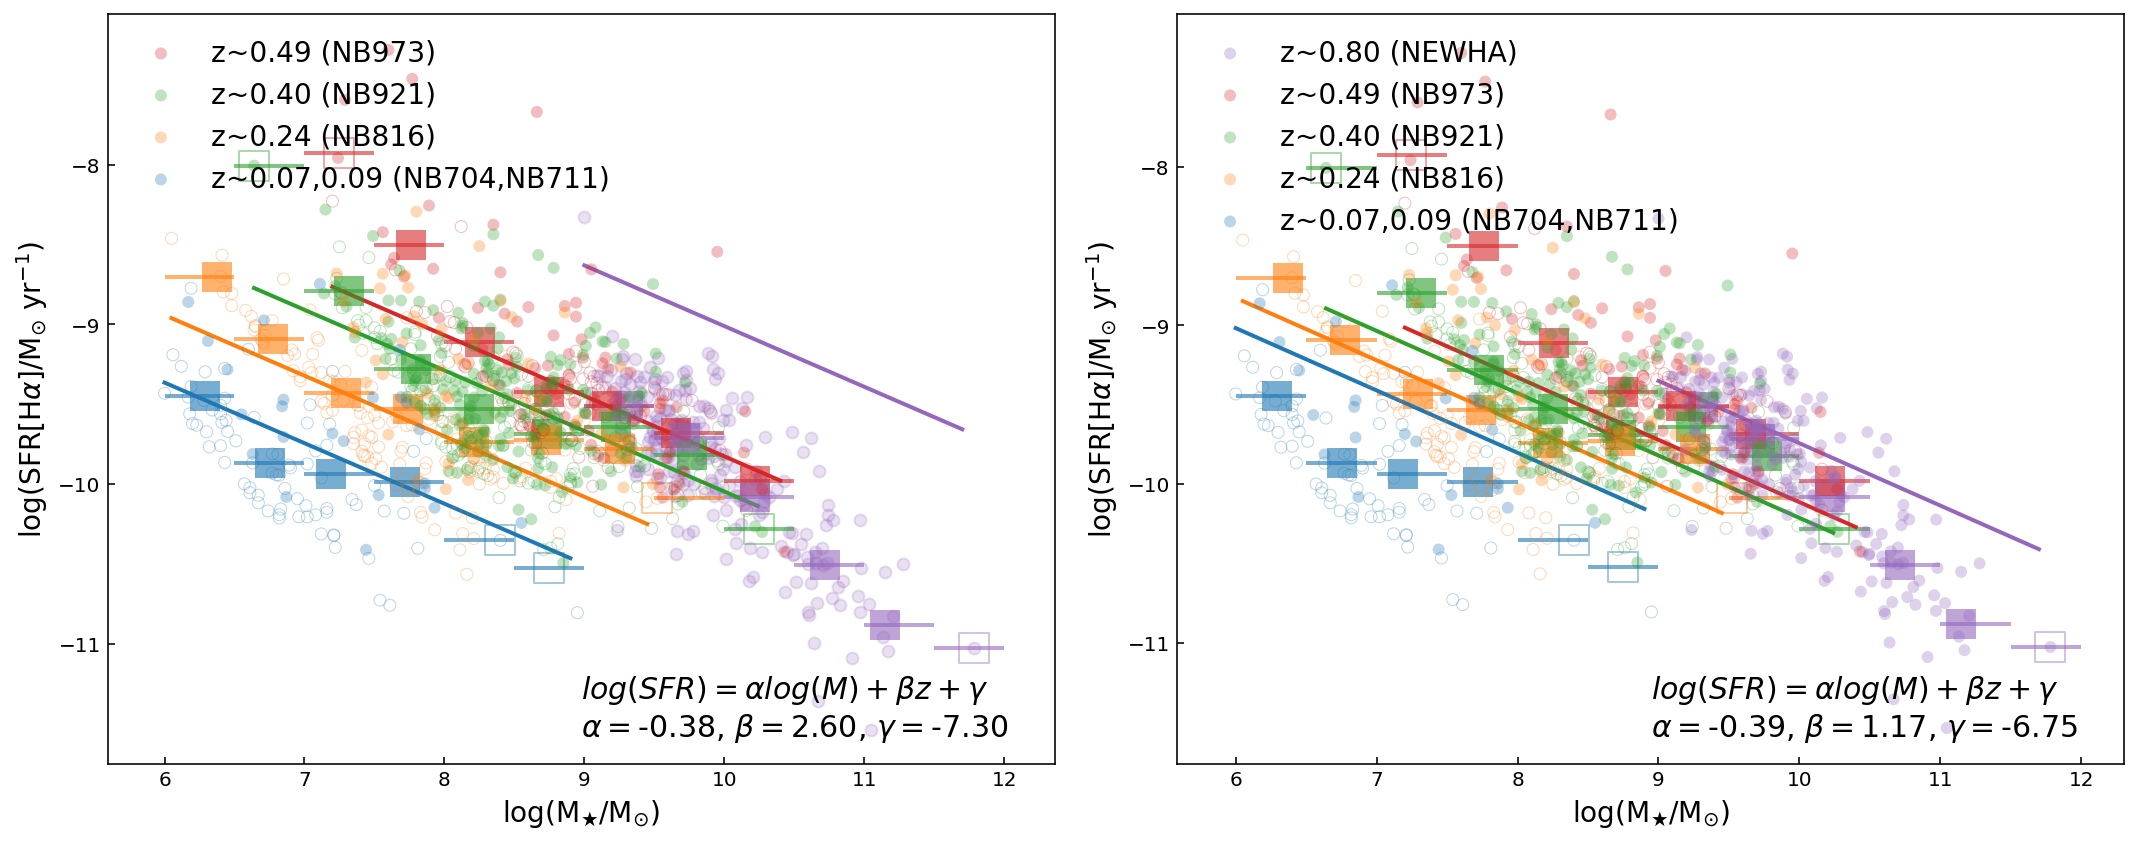

In [199]:
# first order fit
import plot_nbia_mainseq
reload(plot_nbia_mainseq)
from plot_nbia_mainseq import plot_zdep_avg_sfrs, make_redshift_graph

f, axes = plt.subplots(1,2)
for i,ax in enumerate(axes):
    if i==0:
        ssfrs = corr_sfrs - stlr_mass
        newha_ssfrs = newha_logsfrha - newha_logm

        make_redshift_graph(f, ax, z_arr, ssfrs, stlr_mass, zspec0, filts, good_sig_iis, cwheel)

        ax.plot(newha_logm, newha_ssfrs, 'o', c=newha_col, alpha=0.2, zorder=1)
        plot_zdep_avg_sfrs(ax, newha_logm, newha_ssfrs, newha_col)

        mrange = np.arange(min(newha_logm), max(newha_logm), 0.1)
        avgz = np.array([np.mean(newha_zspec)]*len(mrange))
        tmpdata = np.vstack([mrange, avgz]).T
        tmp_params = (-0.38, 2.60, -7.30)
        ax.plot(mrange, func(tmpdata, *tmp_params), color=newha_col, lw=2)
    else:
        ssfrs_with_newha = sfrs_with_newha - mass_with_newha
        make_redshift_graph(f, ax, nh_z_arr, ssfrs_with_newha, mass_with_newha, zspec_with_newha, 
                            filts_with_newha, nh_good_sig_iis, nh_cwheel,
                            ffarr=nh_ffarr, llarr=nh_llarr)


plt.subplots_adjust(hspace=0.01, right=0.99, top=0.98, left=0.1, bottom=0.09)
# f.set_size_inches(24,10)
f.set_size_inches(15,6)
plt.tight_layout()
plt.show()

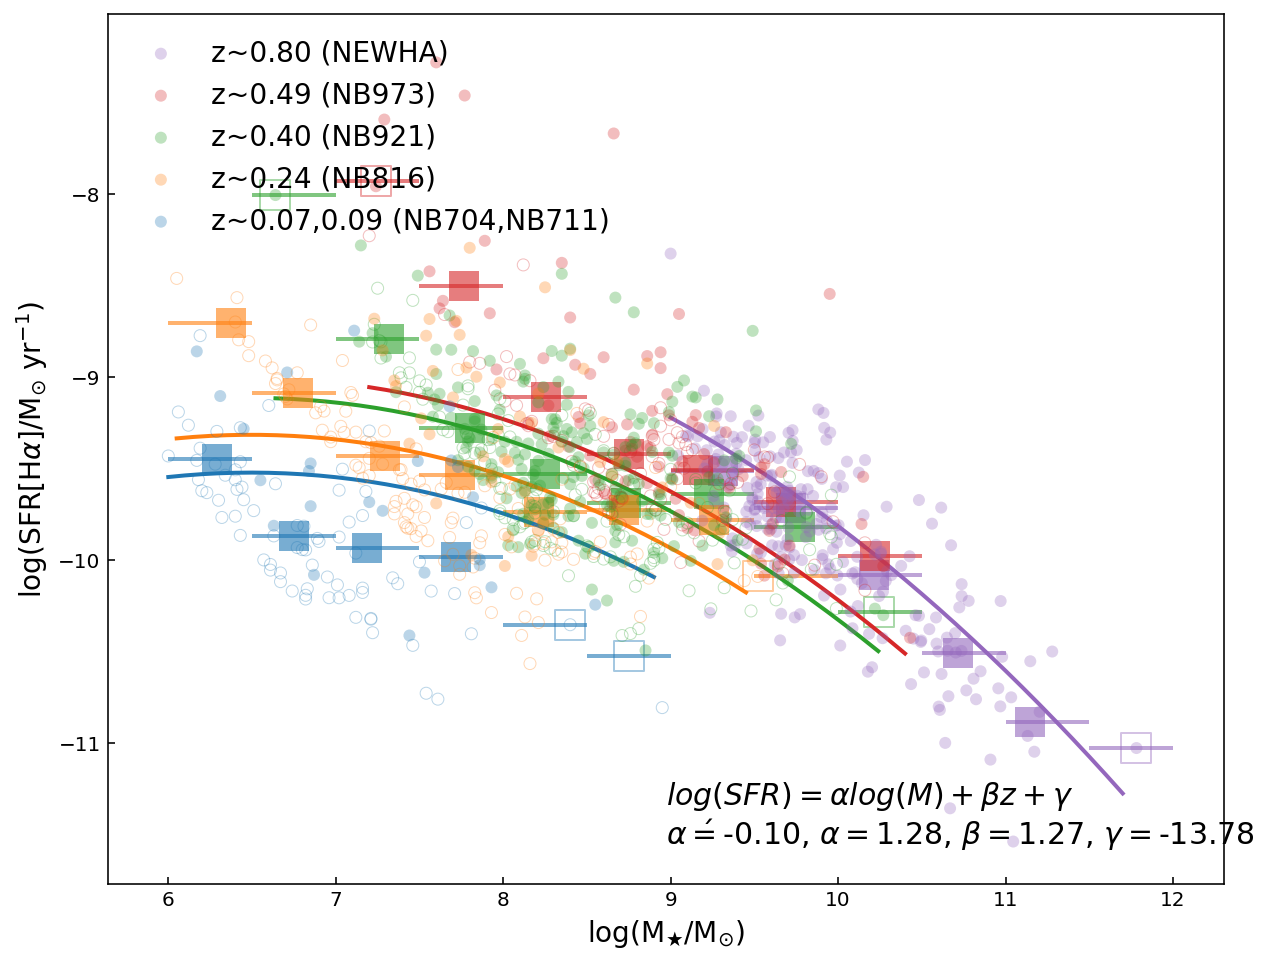

In [205]:
# second order fit
import plot_nbia_mainseq
reload(plot_nbia_mainseq)
from plot_nbia_mainseq import plot_zdep_avg_sfrs, make_redshift_graph

f, ax = plt.subplots()
ssfrs_with_newha = sfrs_with_newha - mass_with_newha
make_redshift_graph(f, ax, nh_z_arr, ssfrs_with_newha, mass_with_newha, zspec_with_newha, 
                    filts_with_newha, nh_good_sig_iis, nh_cwheel,
                    ffarr=nh_ffarr, llarr=nh_llarr, fittype='second_order')
f.set_size_inches(10,8)
plt.show()

### overlaying new_ha sample, but fitting to sSFR instead of SFR 
(SFRs are metallicity-dependent to be more consistent w/ the MACT dataset)

In [206]:
sfrs_with_newha00  = np.concatenate((sfrs, logSFR))
mass_with_newha00  = np.concatenate((mass, newha_logm))
zspec_with_newha00 = np.concatenate((z_sp, newha_zspec))
filts_with_newha00 = np.concatenate((ffs, np.array(['NEWHA']*len(newha_logsfrha))))

['NB7', 'NB816', 'NB921', 'NB973', 'NEWHA']

In [210]:
len(sfrs_with_newha), len(sfrs_with_newha00)

(1320, 1021)

IndexError: index 1021 is out of bounds for axis 1 with size 1021

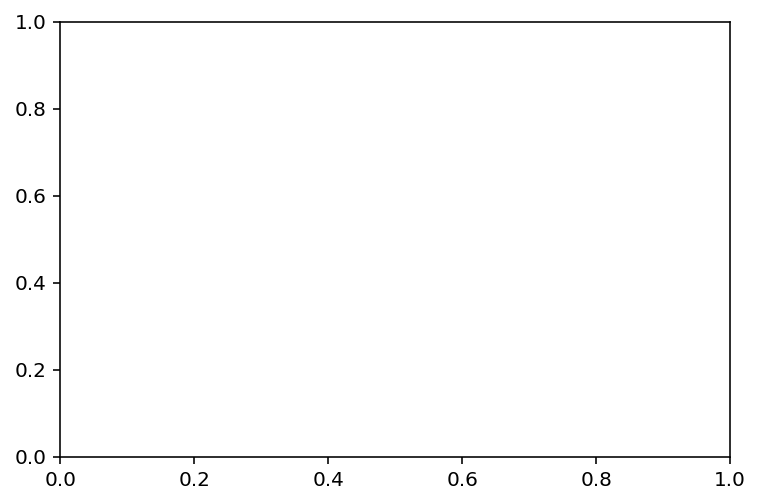

In [207]:
# second order fit
import plot_nbia_mainseq
reload(plot_nbia_mainseq)
from plot_nbia_mainseq import plot_zdep_avg_sfrs, make_redshift_graph

f, ax = plt.subplots()
ssfrs_with_newha00 = sfrs_with_newha00 - mass_with_newha00
make_redshift_graph(f, ax, nh_z_arr, ssfrs_with_newha00, mass_with_newha00, zspec_with_newha00,
                    filts_with_newha00, nh_good_sig_iis, nh_cwheel,
                    ffarr=nh_ffarr, llarr=nh_llarr, fittype='second_order')
f.set_size_inches(10,8)
plt.show()